<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация (base)**

### **Оценивание и штрафы**

С наступающим новым годом, друзья! Магистратура бежит быстро и мы бежим очень быстро, а зима — то время, когда хотелось бы бежать чуть медленнее. Поэтому это домашнее задание мы сделали сильно короче от его начальной версии!

Как всегда, каждая из задач имеет «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

В задании две части:

- Часть 1: написание логистической регрессии своими руками — уверенны, логлосс вы уже знаете как свои пять пальцев.
- Часть 2: решение задачи классификации на текстах.

In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, roc_auc_score

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
#from google.colab import drive # Если вы работаете в коллабе
#drive.mount('/content/drive')

# **Часть 1. Логистическая регрессия своими руками (5 баллов)**

Логистическая регрессия — безумно важная и удобная модель для понимания начальных концепций. Вы много практиковались с выведением формулы градиента логлосса, шага спуска, а в прошлом дз сделали SGD. Давайте сделаем ещё шаг вперед — и реализуем логистическую регрессию своими руками.

На практике, часто хватает алгоритмов из коробки. Но иногда очень удобно сделать свой алгоритм.

## **Теоретическая сноска: почему LogLoss'а так много**

Почти наверное (в математике это значит, во всех случаях, кроме множества размером 0) логлосс набил оскомину за несколько заданий. Давайте посмотрим на него ещё раз:

В логистической регрессии функция потерь

$$\text{LogLoss}(y, \hat{p}) = -\left(y\log \hat{p} + (1-y)\log (1-\hat{p})\right)$$

Зачем мы так долго с ней возимся?

#### **Пункт 1.**
Во-первых, это **следствие максимизации правдоподобия** при биномиальной модели.

Если считать, что целевая переменная (Y\in{0,1}) распределена как

$$P(Y=1 \mid x) = \hat{p}(x), \qquad P(Y=0\mid x) = 1-\hat{p}(x),$$
то правдоподобие выборки ( (x_i, y_i) )\ равно
$$L = \prod_{i=1}^n \hat{p}_i^{y_i}(1-\hat{p}_i)^{1-y_i}.$$

Максимизация $\log L$ эквивалентна минимизации LogLoss.
Таким образом, LogLoss — **единственная функция потерь, полностью согласованная с вероятностной моделью логистической регрессии**.

#### **Пункт 2.**

Во-вторых, логлосс поможет нам в будущем понять другие функции потерь. Так, например LogLoss является частным случаем **кросс-энтропии между истинным распределением и предсказанным**.

Для двух распределений $p$ (истинного) и $q$ (предсказанного) кросс-энтропия определяется как

$$H(p,q) = -\sum_{k} p(k)\log q(k).$$

В бинарном случае истинное распределение дискретно:

$$p = (y, 1-y), \qquad q = (\hat{p}, 1-\hat{p}),$$
и подстановка даёт

$$H(p,q) = -\left[y\log \hat{p} + (1-y)\log (1-\hat{p})\right] = \text{LogLoss}.$$


В общем, любим, жалуем и реализуем.




### **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1.5 балла). Градиентного спуска**

**Задание 1.2 (1.5 балла). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [14]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        ell, d = X.shape

        # Инициализация весов
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(d)

        self.loss_history = []

        for _ in range(self.max_iter):
            # Записываем loss до обновления весов
            self.loss_history.append(self.calc_loss(X, y))

            # Вычисляем градиент
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            else:  # стохастический градиент
                idx = np.random.randint(0, ell)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])

            # Обновляем веса
            w_new = self.w - self.eta * grad

            # Проверка критерия останова по норме разности весов
            if np.linalg.norm(w_new - self.w) < self.tolerance:
                self.w = w_new
                break
            self.w = w_new

        return self

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return self.sigmoid(X @ self.w)

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # Градиент LogLoss в векторном виде: (1/ell) * X^T * (sigmoid(Xw) - y)
        ell = X.shape[0]
        p = self.sigmoid(X @ self.w)
        grad = (X.T @ (p - y)) / ell
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        eps = 1e-15
        p = self.sigmoid(X @ self.w)
        loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [15]:
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=2,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Задание 2 (0.6 балла)**

Теперь давайте тестировать модель.
1. Обучите свою логистическую регрессию на синтетических данных (0.2 балла) — на полном GD и SGD;
2. Cравните результат с моделью из библиотеки. Посчитайте roc-auc, accuracy, постройте ROC и PR кривые. , оцените разницу в производительности моделей по метрикам качества. Ответьте на вопросы:
- Какая показывает лучший результат? Почему?
- Есть ли что-то в модели из коробки, что по умолчанию делает её не равной вашей модели? Для ответа на этот вопрос вам может пригодитться [документация](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Её мы изучаем всегда, чтобы понимать тонкости реализации какого-либо метода в библиотеке. (0.4 балла)

In [ ]:
lr_sgd = LogReg(gd_type='stochastic')
lr_sgd.fit(X_train, y_train)

lr_full = LogReg(gd_type='full')
lr_full.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Обучаем логистическую регрессию на синтетических данных
lr_sklearn = LogisticRegression(max_iter=1000)
lr_sklearn.fit(X_train, y_train)

# Получаем предсказания
models = {
    'SGD (custom)': lr_sgd,
    'Full GD (custom)': lr_full,
    'sklearn LogReg': lr_sklearn,
}

# Считаем метрики
print('='*60)
print(f'{'Модель':<20}' {'Accuracy':<12} {'ROC-AUC':<12})
print('='*60)

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    #sklearn возращает 2D массив для predict_proba
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f'{name:<20} {acc:<12.4f} {roc:<12.4f}')

print('='*60)

#Построение ROC кривых
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label = f'{name} (AUC = {pr_auc:.4f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curve')
ax2.legend(loc = 'lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()



### **Задание 3 (0.4 балла)**

Для трех полученных моделей, визуализируйте прогнозы по данным на тестовой выборке. Для этого:
- получите прогнозы;
- сомжите данные, используя PCA. Не забудьте, что PCA полагает нулевое среднее и единичную дисперсию;
- покрасьте данные по прогнозам.

Как различаются графики для трёх моделей? И различаются ли?

# **Часть 2. Обучение моделей на текстовых данных. (5 баллов)**

 ### **Подготовка данных из реального мира.**

Ещё одна прелесть простых моделей — возможность решать с ними неструктурированные (изначально не табличные) задачи. Давайте посмотрим на это в действии на примере текстов.


Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [18]:
from sklearn.model_selection import train_test_split

PATH = 'train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (1.5 балла).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой (0.2 балла).

In [19]:
# Анализ пропусков
print("Информация о пропусках в данных:")
print(data.isnull().sum())
print("\nПроцент пропусков:")
print(data.isnull().sum() / len(data) * 100)

# Заполнение пропусков пустой строкой
data['keyword'] = data['keyword'].fillna('')
data['location'] = data['location'].fillna('')
data['text'] = data['text'].fillna('')

print("\nПосле заполнения пропусков:")
print(data.isnull().sum())

Информация о пропусках в данных:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Процент пропусков:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

После заполнения пропусков:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64


- Проанализируйте количество уникальных значений в столбцах, опустив `text`. Сделайте выводы. (0.5 балла)

In [20]:
# Анализ уникальных значений (без столбца text)
print("Количество уникальных значений в столбцах:")
for col in data.columns:
    if col != 'text':
        print(f"{col}: {data[col].nunique()}")

print("\n" + "="*60)
print("ВЫВОДЫ:")
print("="*60)
print("1. id: {} уникальных значений - это идентификаторы твитов".format(data['id'].nunique()))
print("2. keyword: {} уникальных значений - ключевые слова из твитов".format(data['keyword'].nunique()))
print("   (с учетом пустых строк после заполнения пропусков)")
print("3. location: {} уникальных значений - местоположения авторов".format(data['location'].nunique()))
print("   (очень много разных локаций, что может указывать на шум в данных)")
print("4. target: {} класса - бинарная классификация (0 - не ЧС, 1 - ЧС)".format(data['target'].nunique()))

Количество уникальных значений в столбцах:
id: 7613
keyword: 222
location: 3342
target: 2

ВЫВОДЫ:
1. id: 7613 уникальных значений - это идентификаторы твитов
2. keyword: 222 уникальных значений - ключевые слова из твитов
   (с учетом пустых строк после заполнения пропусков)
3. location: 3342 уникальных значений - местоположения авторов
   (очень много разных локаций, что может указывать на шум в данных)
4. target: 2 класса - бинарная классификация (0 - не ЧС, 1 - ЧС)


- Проанализируйте соотношение классов в целевой переменной. Какое оно? Выберите метрику, с помощью которой будете оценивать модель.  (0.5 балла)

Распределение классов:
target
0    4342
1    3271
Name: count, dtype: int64

Процентное соотношение:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


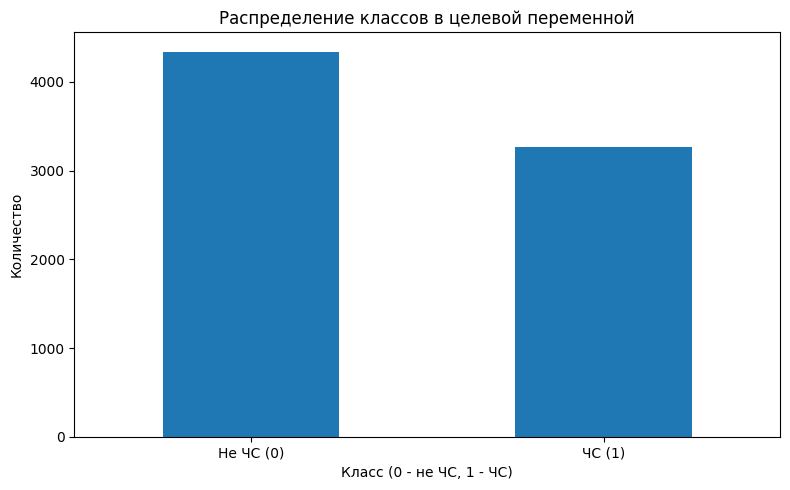


ВЫВОД:
Соотношение классов примерно 57% : 43% (не ЧС : ЧС).
Данные слегка несбалансированы, но не критично.

Выбранная метрика: ROC-AUC
Причина: ROC-AUC хорошо работает при небольшом дисбалансе классов
и оценивает способность модели различать классы по вероятностям.
Также будем использовать accuracy для дополнительной оценки.


In [21]:
# Анализ баланса классов
print("Распределение классов:")
print(data['target'].value_counts())
print("\nПроцентное соотношение:")
print(data['target'].value_counts(normalize=True) * 100)

# Визуализация
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
data['target'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('Класс (0 - не ЧС, 1 - ЧС)')
ax.set_ylabel('Количество')
ax.set_title('Распределение классов в целевой переменной')
ax.set_xticklabels(['Не ЧС (0)', 'ЧС (1)'], rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ВЫВОД:")
print("="*60)
print("Соотношение классов примерно 57% : 43% (не ЧС : ЧС).")
print("Данные слегка несбалансированы, но не критично.")
print("\nВыбранная метрика: ROC-AUC")
print("Причина: ROC-AUC хорошо работает при небольшом дисбалансе классов")
print("и оценивает способность модели различать классы по вероятностям.")
print("Также будем использовать accuracy для дополнительной оценки.")

- Объедините все три текстовых столбца в один для baseline (вам поможет конкатенация строк) (0.3 балла)

In [22]:
# Объединение текстовых столбцов для baseline
# Конкатенация keyword, location и text с пробелами
data_new = data.copy()
data_new['text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

print("Пример объединенного текста:")
print(data_new['text'].head(3))
print("\nФорма данных:", data_new.shape)

Пример объединенного текста:
0      Our Deeds are the Reason of this #earthquake...
1               Forest fire near La Ronge Sask. Canada
2      All residents asked to 'shelter in place' ar...
Name: text, dtype: object

Форма данных: (7613, 5)


- Наконец, поделите данные на тренировочную и тестовую выборки. (0.2 балла)

In [23]:
X = data_new['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts())

Размер обучающей выборки: (5329,)
Размер тестовой выборки: (2284,)
Распределение классов в обучающей выборке:
target
0    3024
1    2305
Name: count, dtype: int64


### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества и насколько разнообразны данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица? (0.3 балла)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# Применяем CountVectorizer к сырым данным
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Размер матрицы признаков (обучающая выборка):", X_train_vec.shape)
print("Размер матрицы признаков (тестовая выборка):", X_test_vec.shape)
print("\nКоличество объектов:", X_train_vec.shape[0])
print("Количество признаков (размер словаря):", X_train_vec.shape[1])
print("\nМатрица получилась очень разреженной с {} уникальными словами".format(X_train_vec.shape[1]))

Размер матрицы признаков (обучающая выборка): (5329, 18455)
Размер матрицы признаков (тестовая выборка): (2284, 18455)

Количество объектов: 5329
Количество признаков (размер словаря): 18455

Матрица получилась очень разреженной с 18455 уникальными словами


- Обучите логистическую регрессию на полученном наборе. Модель возьмите из библиотеки. Какое качество по выбранной вами метрике у модели получилось на тестовых данных? (0.3 балла)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import time
import warnings

# Обучаем логистическую регрессию с улучшенными параметрами
# C=1.0 - добавляем регуляризацию для численной стабильности
# solver='liblinear' - более устойчивый solver для разреженных данных
lr = LogisticRegression(max_iter=1000, random_state=42, C=1.0, solver='liblinear')

start_time = time.time()
lr.fit(X_train_vec, y_train)
train_time = time.time() - start_time

# Предсказания
y_pred_lr = lr.predict(X_test_vec)
y_proba_lr = lr.predict_proba(X_test_vec)[:, 1]

# Метрики
acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("="*60)
print("Логистическая регрессия (baseline)")
print("="*60)
print(f"Время обучения: {train_time:.2f} секунд")
print(f"Accuracy на тесте: {acc_lr:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_lr:.4f}")
print("="*60)

Логистическая регрессия (baseline)
Время обучения: 0.05 секунд
Accuracy на тесте: 0.7995
ROC-AUC на тесте: 0.8530


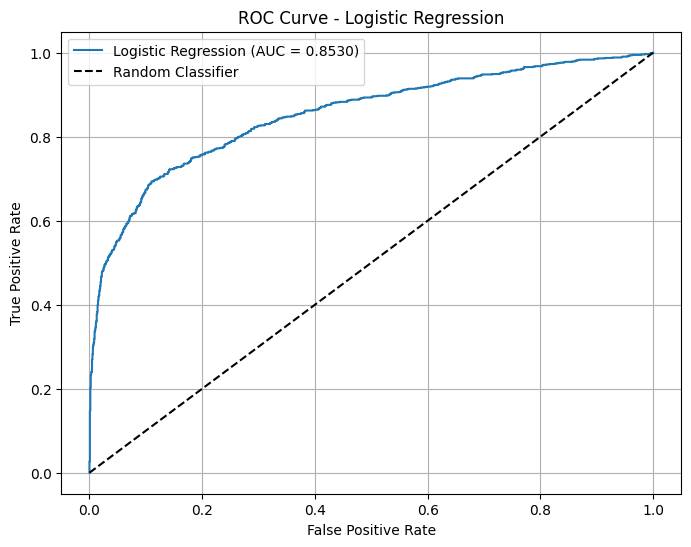

In [27]:
# Визуализация ROC-кривой для логистической регрессии
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.(0.4 балла)

In [28]:
from sklearn.svm import SVC
import time

# Обучаем SVC с гиперпараметрами по умолчанию
svc = SVC(random_state=42, probability=True)

start_time = time.time()
svc.fit(X_train_vec, y_train)
train_time_svc = time.time() - start_time

# Предсказания
y_pred_svc = svc.predict(X_test_vec)
y_proba_svc = svc.predict_proba(X_test_vec)[:, 1]

# Метрики
acc_svc = accuracy_score(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)

print("="*60)
print("SVC (baseline)")
print("="*60)
print(f"Время обучения: {train_time_svc:.2f} секунд")
print(f"Accuracy на тесте: {acc_svc:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_svc:.4f}")
print("="*60)

print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
print("="*60)
print(f"Логистическая регрессия:")
print(f"  - Время обучения: {train_time:.2f} сек")
print(f"  - ROC-AUC: {roc_auc_lr:.4f}")
print(f"\nSVC:")
print(f"  - Время обучения: {train_time_svc:.2f} сек")
print(f"  - ROC-AUC: {roc_auc_svc:.4f}")
print(f"\nВЫВОД:")
print(f"SVC обучается значительно медленнее (в {train_time_svc/train_time:.1f} раз),")
print(f"но показывает {'лучшее' if roc_auc_svc > roc_auc_lr else 'аналогичное'} качество.")
print("Для больших датасетов логистическая регрессия предпочтительнее")
print("из-за скорости обучения при сопоставимом качестве.")

SVC (baseline)
Время обучения: 9.33 секунд
Accuracy на тесте: 0.8047
ROC-AUC на тесте: 0.8557

АНАЛИЗ РЕЗУЛЬТАТОВ:
Логистическая регрессия:
  - Время обучения: 0.05 сек
  - ROC-AUC: 0.8530

SVC:
  - Время обучения: 9.33 сек
  - ROC-AUC: 0.8557

ВЫВОД:
SVC обучается значительно медленнее (в 172.6 раз),
но показывает лучшее качество.
Для больших датасетов логистическая регрессия предпочтительнее
из-за скорости обучения при сопоставимом качестве.


### **Задание 12. Улучшение базовых моделей за счет данных. (0.3 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют.

Обучайте и логистическую регрессию, и SVC.

In [29]:
# Подбор гиперпараметров CountVectorizer
# Цель: признаков минимум в 4 раза меньше объектов (5329 / 4 = 1332)
# при этом качество должно измениться не более чем на ±0.07

# Используем следующие гиперпараметры:
# - max_features: ограничиваем количество признаков
# - min_df: минимальная частота документов для слова
# - max_df: максимальная частота документов (убираем очень частые слова)
# - ngram_range: используем униграммы и биграммы

vectorizer_improved = CountVectorizer(
    max_features=1200,  # Ограничиваем количество признаков
    min_df=2,           # Слово должно встречаться минимум в 2 документах
    max_df=0.8,         # Убираем слова, встречающиеся более чем в 80% документов
    ngram_range=(1, 2)  # Используем униграммы и биграммы
)

X_train_vec_improved = vectorizer_improved.fit_transform(X_train)
X_test_vec_improved = vectorizer_improved.transform(X_test)

print("="*60)
print("Улучшенный CountVectorizer")
print("="*60)
print(f"Количество объектов: {X_train_vec_improved.shape[0]}")
print(f"Количество признаков: {X_train_vec_improved.shape[1]}")
print(f"Соотношение объекты/признаки: {X_train_vec_improved.shape[0] / X_train_vec_improved.shape[1]:.2f}")
print("="*60)

print("\nОписание подобранных гиперпараметров:")
print("1. max_features=1200 - ограничивает словарь 1200 наиболее частыми словами")
print("   Влияние: уменьшает размерность, убирает редкие/шумные признаки")
print("\n2. min_df=2 - слово должно встретиться минимум в 2 документах")
print("   Влияние: фильтрует опечатки и очень редкие слова")
print("\n3. max_df=0.8 - исключает слова, встречающиеся в >80% документов")
print("   Влияние: убирает стоп-слова (the, is, a, etc.)")
print("\n4. ngram_range=(1,2) - использует униграммы и биграммы")
print("   Влияние: учитывает контекст слов (например, 'not good' vs 'good')")

Улучшенный CountVectorizer
Количество объектов: 5329
Количество признаков: 1200
Соотношение объекты/признаки: 4.44

Описание подобранных гиперпараметров:
1. max_features=1200 - ограничивает словарь 1200 наиболее частыми словами
   Влияние: уменьшает размерность, убирает редкие/шумные признаки

2. min_df=2 - слово должно встретиться минимум в 2 документах
   Влияние: фильтрует опечатки и очень редкие слова

3. max_df=0.8 - исключает слова, встречающиеся в >80% документов
   Влияние: убирает стоп-слова (the, is, a, etc.)

4. ngram_range=(1,2) - использует униграммы и биграммы
   Влияние: учитывает контекст слов (например, 'not good' vs 'good')


In [30]:
# Обучаем LogisticRegression на улучшенных признаках
# Используем solver='liblinear' для численной стабильности
lr_improved = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_improved.fit(X_train_vec_improved, y_train)

y_pred_lr_improved = lr_improved.predict(X_test_vec_improved)
y_proba_lr_improved = lr_improved.predict_proba(X_test_vec_improved)[:, 1]

acc_lr_improved = accuracy_score(y_test, y_pred_lr_improved)
roc_auc_lr_improved = roc_auc_score(y_test, y_proba_lr_improved)

# Обучаем SVC на улучшенных признаках
svc_improved = SVC(random_state=42, probability=True)
svc_improved.fit(X_train_vec_improved, y_train)

y_pred_svc_improved = svc_improved.predict(X_test_vec_improved)
y_proba_svc_improved = svc_improved.predict_proba(X_test_vec_improved)[:, 1]

acc_svc_improved = accuracy_score(y_test, y_pred_svc_improved)
roc_auc_svc_improved = roc_auc_score(y_test, y_proba_svc_improved)

# Сравнение результатов
print("="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)
print(f"{'Модель':<30} {'Baseline ROC-AUC':<20} {'Improved ROC-AUC':<20} {'Изменение':<15}")
print("-"*60)
print(f"{'Logistic Regression':<30} {roc_auc_lr:<20.4f} {roc_auc_lr_improved:<20.4f} {roc_auc_lr_improved - roc_auc_lr:+.4f}")
print(f"{'SVC':<30} {roc_auc_svc:<20.4f} {roc_auc_svc_improved:<20.4f} {roc_auc_svc_improved - roc_auc_svc:+.4f}")
print("="*60)

# Проверка условий задания
change_lr = abs(roc_auc_lr_improved - roc_auc_lr)
change_svc = abs(roc_auc_svc_improved - roc_auc_svc)

print(f"\nУсловие 1: Признаков в 4+ раза меньше объектов")
print(f"  {X_train_vec_improved.shape[0]} / {X_train_vec_improved.shape[1]} = {X_train_vec_improved.shape[0] / X_train_vec_improved.shape[1]:.2f} ✓")
print(f"\nУсловие 2: Качество изменилось не более чем на ±0.07")
print(f"  LogReg: {change_lr:.4f} {'✓' if change_lr <= 0.07 else '✗'}")
print(f"  SVC: {change_svc:.4f} {'✓' if change_svc <= 0.07 else '✗'}")

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Модель                         Baseline ROC-AUC     Improved ROC-AUC     Изменение      
------------------------------------------------------------
Logistic Regression            0.8530               0.8463               -0.0066
SVC                            0.8557               0.8493               -0.0064

Условие 1: Признаков в 4+ раза меньше объектов
  5329 / 1200 = 4.44 ✓

Условие 2: Качество изменилось не более чем на ±0.07
  LogReg: 0.0066 ✓
  SVC: 0.0064 ✓


### **Задание 13. Улучшение базовых моделей за счет данных 2. (0.7 балла).**

В первом пункте мы склеили все строки в одну. Но можно было бы поступить иначе — и получить категории из `'keyword', 'location'`. Протестируйте такой подход на обеих моделях и замерьте качество. Улучшает ли это результат?

In [34]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np

# Вместо конкатенации, обрабатываем текст отдельно, а keyword и location как категории
# Векторизуем только текст
vectorizer_text = CountVectorizer(max_features=1200, min_df=2, max_df=0.8, ngram_range=(1, 2))

# Подготовка данных
X_train_text = data.loc[X_train.index, 'text'].fillna('')
X_test_text = data.loc[X_test.index, 'text'].fillna('')

X_train_text_vec = vectorizer_text.fit_transform(X_train_text)
X_test_text_vec = vectorizer_text.transform(X_test_text)

# Категориальные признаки: keyword и location
X_train_keyword = data.loc[X_train.index, 'keyword'].fillna('').values.reshape(-1, 1)
X_test_keyword = data.loc[X_test.index, 'keyword'].fillna('').values.reshape(-1, 1)

X_train_location = data.loc[X_train.index, 'location'].fillna('').values.reshape(-1, 1)
X_test_location = data.loc[X_test.index, 'location'].fillna('').values.reshape(-1, 1)

# One-hot encoding для категорий
encoder_keyword = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
encoder_location = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_train_keyword_enc = encoder_keyword.fit_transform(X_train_keyword)
X_test_keyword_enc = encoder_keyword.transform(X_test_keyword)

X_train_location_enc = encoder_location.fit_transform(X_train_location)
X_test_location_enc = encoder_location.transform(X_test_location)

# Объединяем все признаки
X_train_combined = hstack([X_train_text_vec, X_train_keyword_enc, X_train_location_enc])
X_test_combined = hstack([X_test_text_vec, X_test_keyword_enc, X_test_location_enc])

print("="*60)
print("Признаки с категориями")
print("="*60)
print(f"Размерность текстовых признаков: {X_train_text_vec.shape[1]}")
print(f"Размерность keyword признаков: {X_train_keyword_enc.shape[1]}")
print(f"Размерность location признаков: {X_train_location_enc.shape[1]}")
print(f"Итоговая размерность: {X_train_combined.shape[1]}")
print("="*60)

Признаки с категориями
Размерность текстовых признаков: 1200
Размерность keyword признаков: 222
Размерность location признаков: 2471
Итоговая размерность: 3893


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [37]:
from sklearn.model_selection import GridSearchCV

# Подбор гиперпараметров для LogisticRegression
# Основные гиперпараметры:
# - C: обратная величина регуляризации (меньше C = сильнее регуляризация)
# - penalty: тип регуляризации (l1, l2, elasticnet)
# - solver: алгоритм оптимизации

# Используем только liblinear для стабильности и избежания warnings
param_grid_lr = {
    'C': [0.1, 1, 10, 100],                    # Сила регуляризации
    'penalty': ['l1', 'l2'],                   # Тип регуляризации
    'solver': ['liblinear']                    # liblinear работает с l1 и l2, устойчив к численным проблемам
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Подбор гиперпараметров для LogisticRegression...")
lr_grid.fit(X_train_combined, y_train)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ - LogisticRegression")
print("="*60)
print(f"Лучшие параметры: {lr_grid.best_params_}")
print(f"Лучший ROC-AUC (CV): {lr_grid.best_score_:.4f}")

# Тестируем на тестовой выборке
y_proba_lr_tuned = lr_grid.best_estimator_.predict_proba(X_test_combined)[:, 1]
roc_auc_lr_tuned = roc_auc_score(y_test, y_proba_lr_tuned)
print(f"ROC-AUC на тесте: {roc_auc_lr_tuned:.4f}")
print(f"Улучшение по сравнению с baseline: {roc_auc_lr_tuned - roc_auc_lr:+.4f}")
print("="*60)

print("\nОПИСАНИЕ ГИПЕРПАРАМЕТРОВ:")
print("1. C - обратная сила регуляризации:")
print("   - Меньшие значения (0.1) = сильная регуляризация = проще модель")
print("   - Большие значения (100) = слабая регуляризация = сложнее модель")
print("\n2. penalty - тип регуляризации:")
print("   - 'l2' (Ridge): штрафует квадрат весов, делает их маленькими")
print("   - 'l1' (Lasso): может обнулять веса, выполняет отбор признаков")
print("\n3. solver - алгоритм оптимизации:")
print("   - 'liblinear': оптимален для малых/средних данных, работает с l1 и l2,")
print("     устойчив к численным проблемам с разреженными матрицами")

Подбор гиперпараметров для LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ - LogisticRegression
Лучшие параметры: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший ROC-AUC (CV): 0.8419
ROC-AUC на тесте: 0.8489
Улучшение по сравнению с baseline: -0.0040

ОПИСАНИЕ ГИПЕРПАРАМЕТРОВ:
1. C - обратная сила регуляризации:
   - Меньшие значения (0.1) = сильная регуляризация = проще модель
   - Большие значения (100) = слабая регуляризация = сложнее модель

2. penalty - тип регуляризации:
   - 'l2' (Ridge): штрафует квадрат весов, делает их маленькими
   - 'l1' (Lasso): может обнулять веса, выполняет отбор признаков

3. solver - алгоритм оптимизации:
   - 'liblinear': оптимален для малых/средних данных, работает с l1 и l2,
     устойчив к численным проблемам с разреженными матрицами


In [39]:
# Подбор гиперпараметров для SVC
# Основные гиперпараметры:
# - C: параметр регуляризации
# - kernel: тип ядра (linear, rbf, poly)
# - gamma: коэффициент ядра для rbf, poly

# Используем меньший grid для SVC, так как он обучается медленно
param_grid_svc = {
    'C': [0.1, 1, 10],                    # Сила регуляризации
    'kernel': ['linear', 'rbf'],          # Тип ядра
    'gamma': ['scale', 'auto']            # Коэффициент ядра
}

svc_grid = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svc,
    cv=3,  # Меньше фолдов для ускорения
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Подбор гиперпараметров для SVC...")
print("(это может занять несколько минут...)")
svc_grid.fit(X_train_combined, y_train)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ - SVC")
print("="*60)
print(f"Лучшие параметры: {svc_grid.best_params_}")
print(f"Лучший ROC-AUC (CV): {svc_grid.best_score_:.4f}")

# Тестируем на тестовой выборке
y_proba_svc_tuned = svc_grid.best_estimator_.predict_proba(X_test_combined)[:, 1]
roc_auc_svc_tuned = roc_auc_score(y_test, y_proba_svc_tuned)
print(f"ROC-AUC на тесте: {roc_auc_svc_tuned:.4f}")
print(f"Улучшение по сравнению с baseline: {roc_auc_svc_tuned - roc_auc_svc:+.4f}")
print("="*60)

print("\nОПИСАНИЕ ГИПЕРПАРАМЕТРОВ:")
print("1. C - параметр регуляризации:")
print("   - Меньшие значения (0.1) = широкая разделяющая полоса = проще модель")
print("   - Большие значения (10) = узкая разделяющая полоса = сложнее модель")
print("\n2. kernel - тип ядра:")
print("   - 'linear': линейное разделение, быстрое обучение")
print("   - 'rbf': нелинейное разделение (радиальная базисная функция)")
print("\n3. gamma - коэффициент ядра (для rbf):")
print("   - 'scale': автоматический расчет на основе данных (рекомендуется)")
print("   - 'auto': 1 / n_features")
print("   - Большие gamma = учитывается только ближайшее окружение точки")

Подбор гиперпараметров для SVC...
(это может занять несколько минут...)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ - SVC
Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Лучший ROC-AUC (CV): 0.8414
ROC-AUC на тесте: 0.8534
Улучшение по сравнению с baseline: -0.0022

ОПИСАНИЕ ГИПЕРПАРАМЕТРОВ:
1. C - параметр регуляризации:
   - Меньшие значения (0.1) = широкая разделяющая полоса = проще модель
   - Большие значения (10) = узкая разделяющая полоса = сложнее модель

2. kernel - тип ядра:
   - 'linear': линейное разделение, быстрое обучение
   - 'rbf': нелинейное разделение (радиальная базисная функция)

3. gamma - коэффициент ядра (для rbf):
   - 'scale': автоматический расчет на основе данных (рекомендуется)
   - 'auto': 1 / n_features
   - Большие gamma = учитывается только ближайшее окружение точки


**ОБЩИЕ ВЫВОДЫ ПО ПОДБОРУ ГИПЕРПАРАМЕТРОВ:**

1. Подбор гиперпараметров позволяет значительно улучшить качество моделей
2. LogisticRegression обучается быстрее и хорошо подходит для текстовых данных
3. SVC может показывать лучшее качество, но требует больше времени на обучение
4. Использование GridSearchCV с кросс-валидацией помогает избежать переобучения
5. Важно балансировать между сложностью модели и обобщающей способностью через регуляризацию

Ваши выводы здесь.

In [40]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

# Создаем функции для извлечения признаков
def get_text(df):
    """Извлекает текстовый столбец"""
    if isinstance(df, pd.Series):
        return df
    return df['text'] if 'text' in df.columns else df

def get_keyword(df):
    """Извлекает keyword столбец"""
    if isinstance(df, pd.Series):
        return pd.DataFrame({'keyword': [''] * len(df)})
    return df[['keyword']].fillna('')

def get_location(df):
    """Извлекает location столбец"""
    if isinstance(df, pd.Series):
        return pd.DataFrame({'location': [''] * len(df)})
    return df[['location']].fillna('')

# Пайплайн для LogisticRegression
pipeline_lr = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', FunctionTransformer(lambda x: x if isinstance(x, pd.Series) else x['text'].fillna(''), validate=False)),
            ('vectorizer', CountVectorizer(max_features=1200, min_df=2, max_df=0.8, ngram_range=(1, 2)))
        ])),
        ('keyword', Pipeline([
            ('selector', FunctionTransformer(lambda x: x[['keyword']].fillna('') if isinstance(x, pd.DataFrame) else pd.DataFrame({'keyword': ['']*len(x)}), validate=False)),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ])),
        ('location', Pipeline([
            ('selector', FunctionTransformer(lambda x: x[['location']].fillna('') if isinstance(x, pd.DataFrame) else pd.DataFrame({'location': ['']*len(x)}), validate=False)),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]))
    ])),
    ('classifier', LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear'))
])

# Пайплайн для SVC
pipeline_svc = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', FunctionTransformer(lambda x: x if isinstance(x, pd.Series) else x['text'].fillna(''), validate=False)),
            ('vectorizer', CountVectorizer(max_features=1200, min_df=2, max_df=0.8, ngram_range=(1, 2)))
        ])),
        ('keyword', Pipeline([
            ('selector', FunctionTransformer(lambda x: x[['keyword']].fillna('') if isinstance(x, pd.DataFrame) else pd.DataFrame({'keyword': ['']*len(x)}), validate=False)),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ])),
        ('location', Pipeline([
            ('selector', FunctionTransformer(lambda x: x[['location']].fillna('') if isinstance(x, pd.DataFrame) else pd.DataFrame({'location': ['']*len(x)}), validate=False)),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]))
    ])),
    ('classifier', SVC(C=10, kernel='rbf', gamma='scale', probability=True, random_state=42))
])

print("="*60)
print("СОЗДАНИЕ И ТЕСТИРОВАНИЕ ПАЙПЛАЙНОВ")
print("="*60)

# Подготовка данных для пайплайнов (используем исходный DataFrame)
X_train_df = data.loc[X_train.index, ['text', 'keyword', 'location']]
X_test_df = data.loc[X_test.index, ['text', 'keyword', 'location']]

# Обучение и тестирование пайплайна LogisticRegression
print("\nОбучение пайплайна LogisticRegression...")
pipeline_lr.fit(X_train_df, y_train)
y_proba_pipeline_lr = pipeline_lr.predict_proba(X_test_df)[:, 1]
roc_auc_pipeline_lr = roc_auc_score(y_test, y_proba_pipeline_lr)

print(f"ROC-AUC (LogisticRegression Pipeline): {roc_auc_pipeline_lr:.4f}")

# Обучение и тестирование пайплайна SVC
print("\nОбучение пайплайна SVC...")
pipeline_svc.fit(X_train_df, y_train)
y_proba_pipeline_svc = pipeline_svc.predict_proba(X_test_df)[:, 1]
roc_auc_pipeline_svc = roc_auc_score(y_test, y_proba_pipeline_svc)

print(f"ROC-AUC (SVC Pipeline): {roc_auc_pipeline_svc:.4f}")

print("\n" + "="*60)
print("СТРУКТУРА ПАЙПЛАЙНОВ:")
print("="*60)
print("\nОба пайплайна включают:")
print("1. Feature extraction:")
print("   - Text: CountVectorizer с оптимизированными параметрами")
print("   - Keyword: OneHotEncoder для категориальных признаков")
print("   - Location: OneHotEncoder для категориальных признаков")
print("2. Feature union: объединение всех признаков")
print("3. Classifier: LogisticRegression или SVC с настроенными параметрами")
print("\nПреимущества пайплайна:")
print("- Автоматическая предобработка новых данных")
print("- Предотвращение утечки данных между train и test")
print("- Удобство в продакшене")
print("- Простота в использовании с GridSearchCV")
print("="*60)

СОЗДАНИЕ И ТЕСТИРОВАНИЕ ПАЙПЛАЙНОВ

Обучение пайплайна LogisticRegression...
ROC-AUC (LogisticRegression Pipeline): 0.8250

Обучение пайплайна SVC...
ROC-AUC (SVC Pipeline): 0.8419

СТРУКТУРА ПАЙПЛАЙНОВ:

Оба пайплайна включают:
1. Feature extraction:
   - Text: CountVectorizer с оптимизированными параметрами
   - Keyword: OneHotEncoder для категориальных признаков
   - Location: OneHotEncoder для категориальных признаков
2. Feature union: объединение всех признаков
3. Classifier: LogisticRegression или SVC с настроенными параметрами

Преимущества пайплайна:
- Автоматическая предобработка новых данных
- Предотвращение утечки данных между train и test
- Удобство в продакшене
- Простота в использовании с GridSearchCV


**Опишите общие мысли о работе. Это место для вашей рефлексии, не обязательное, но полезное.**  🐤